# Importy

In [1]:
import pandas as pd
from IPython.display import display

# APICommunication
import APICommunication.config as cfg

# Data
from Data.DataLoader import *
from Data.DataCleaner import *

# MarkowitzAnalysis
from MarkowitzAnalysis.ReturnAnalysis import *

# PortfolioAnalysis
from PortfolioAnalysis.PortfolioPerformance import *
from PortfolioAnalysis.PortfolioLoader import *

# PositionAnalysis
from PositionAnalysis.PositionManipulations import *

# Plotting
from Plotting.Plotter import *
from Plotting.EfficientFrontierPlot import *

# Backtest
from Backtest.Backtest import *

from warnings import filterwarnings
filterwarnings('ignore')

# Działanie właściwego programu

## Scenariusz 0. Aktualizacja danych do obecnej daty

In [3]:
start, end = '2025-02-16', '2025-03-01'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)

[INFO] Rozpoczynam pracę programu: 2025-03-01 16:40:52
	Pobieramy brakujące dane od 2025-02-17 do 2025-03-01...
	Pozostało 100%.
		[1] Pobieram IU5C.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[2] Pobieram SYBL.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[3] Pobieram U3O8.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[4] Pobieram UETW.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[5] Pobieram XMME.UK.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[6] Pobieram SGAS.DE_9.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[7] Pobieram SUSM.UK.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[8] Pobieram PRFD.UK.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[9] Pobieram RIZJ.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[10] Pobieram IBZL.NL.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[1] Pobieram PR1E.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.

[2025-03-01 18:06:46,789][connect:59] SockThread Error: [Errno 11001] getaddrinfo failed


		[1] Pobieram IUS3.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[2] Pobieram BCHN.UK.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[3] Pobieram XEMD.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[4] Pobieram CEBL.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[5] Pobieram V3PA.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[6] Pobieram DBZB.DE_9.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[7] Pobieram W1TB.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[8] Pobieram EUNU.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[9] Pobieram H4ZF.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[10] Pobieram ASRD.DE.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[1] Pobieram CSH.FR.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[2] Pobieram SRTY.US.
		Wysyłam zapytanie do API... 
		[INFO] Dane zapisane.
		[3] Pobieram FGEQ.DE.
		Wysyłam zapytanie do API

## Scenariusz 1. Analiza obecnej pozycji przez łączenie z API

In [4]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dl = DataLoader(cfg.user_id, cfg.pwd)
info = dl.loadInstrumentsInfo()

pm = PositionManipulator(cfg.user_id, 
                         cfg.pwd, 
                         info=info,
                         filename_load='Pozycja od 10.12.2024 do 10.03.2025',
                         filepath_load='Positions')
pa = pm.AnalyzePosition()

display(pa.getSummary())

print(f"Zwrot z portfela: {pa.getPCTReturn()}%")
print(f"Zysk z inwestycji: {pa.getPLNReturn()} PLN")

[INFO] Rozpoczynam pracę programu: 2025-02-28 15:36:34
		Wysyłam zapytanie do API... 		Wysyłam zapytanie do API... 		Wysyłam zapytanie do API... 		Wysyłam zapytanie do API... 

,ESD.FR,P500.DE,4GLD.DE,FLXI.DE
CzasOtwarcia,2024-12-10 15:51:46,2024-12-10 15:50:41,2024-12-10 15:52:16,2024-12-10 15:51:14
WartoscPoczatkowaPLN,58.99,389.79,210.0,539.99
CenaOtwarcia,24.307,1134.05,82.2,43.55
CenaAktualna,23.418,1112.5,87.855,37.57
Zwrot [%],-3.657383,-1.900269,6.879562,-13.731343
KursWalutowyOtwarcia,4.077424,4.281605,4.281605,4.281605
KursWalutowyAktualny,3.965771,4.128454,4.128454,4.128454
ZwrotWalutowy [%],-2.73831,-3.576953,-3.576953,-3.576953
CenaOtwarciaPLN,99.109945,4855.55415,351.947931,186.463898
CenaAktualnaPLN,92.870437,4592.905075,362.705326,155.106017


Zwrot z portfela: -9.11%
Zysk z inwestycji: -109.19 PLN


## Scenariusz 2. Wybór nowej pozycji

In [150]:
start, end = '2025-02-17', '2025-02-28'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end, filename='InstrumentsData')
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, verbose=False)
datacleaner.updateData(['SPYC.DE', 'EHLT.DE', 'X7PS.DE',
                        'SPYH.DE', 'LHTC.DE', 'S7XE.DE',
                        'DXSK.DE', 'HDLV.DE', 'LYBK.DE',
                        'LBNK.DE'], method='drop')

freq = '1w'
returnRates = datacleaner.getReturnRates(freq)
mo = MarkowitzOptimization(returnRates, freq)
mo.getOptimalWeights(model='max_sharpe', risk_method='oas')
portfolio = mo.getPortfolio()
# print(portfolio.symbols)

# Możemy zapoznać się ze statystykami zaproponowanej pozycji
print()
portfolio.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-03-03 16:54:21
[INFO] Załadowano 932 instrumentów.

Opis wygenerowany 2025-03-03 16:54:39.
Okres inwestycji: 1w.
Zastosowane kryterium wyboru: max_sharpe.
Metoda estymacji ryzyka: oas.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 1.0279
Oczekiwane ryzyko portfela [%]: 0.4599
Przedział ufności dla stóp zwrotu [%]: [0.8746, 1.3436]
Sharpe Ratio portfela: 1.9871
Skład portfela:
	DXSE.DE:
		Waga w portfelu [%]: 15.917
		Oczekiwana stopa zwrotu [%]: 0.4535
		Oczekiwana stopa ryzyka [%]: 0.9193
		Przedział ufności dla stóp zwrotu [%]: [-0.3141, 0.7887]
	BNKE.FR:
		Waga w portfelu [%]: 14.804
		Oczekiwana stopa zwrotu [%]: 1.7849
		Oczekiwana stopa ryzyka [%]: 1.473
		Przedział ufności dla stóp zwrotu [%]: [-0.1798, 3.1446]
	WELD.DE:
		Waga w portfelu [%]: 8.896
		Oczekiwana stopa zwrotu [%]: 0.0962
		Oczekiwana stopa ryzyka [%]: 0.8629
		Przedział ufności dla stóp zwrotu [%]: [-0.2133, 0.1787]
	DTLE.UK:
		Waga w portfelu [%]: 8.709
		Oczekiwa

#### Scenariusz 2a. Statystyki nas zainteresowały i chcemy zapisać rekomendację na później.

In [151]:
portfolio.getSummary(save_dict=True, filename='pos1', filepath='Recommendations')

Opis wygenerowany 2025-03-03 16:55:19.
Okres inwestycji: 1w.
Zastosowane kryterium wyboru: max_sharpe.
Metoda estymacji ryzyka: oas.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 1.0279
Oczekiwane ryzyko portfela [%]: 0.4599
Przedział ufności dla stóp zwrotu [%]: [0.8746, 1.3436]
Sharpe Ratio portfela: 1.9871
Skład portfela:
	DXSE.DE:
		Waga w portfelu [%]: 15.917
		Oczekiwana stopa zwrotu [%]: 0.4535
		Oczekiwana stopa ryzyka [%]: 0.9193
		Przedział ufności dla stóp zwrotu [%]: [-0.3141, 0.7887]
	BNKE.FR:
		Waga w portfelu [%]: 14.804
		Oczekiwana stopa zwrotu [%]: 1.7849
		Oczekiwana stopa ryzyka [%]: 1.473
		Przedział ufności dla stóp zwrotu [%]: [-0.1798, 3.1446]
	WELD.DE:
		Waga w portfelu [%]: 8.896
		Oczekiwana stopa zwrotu [%]: 0.0962
		Oczekiwana stopa ryzyka [%]: 0.8629
		Przedział ufności dla stóp zwrotu [%]: [-0.2133, 0.1787]
	DTLE.UK:
		Waga w portfelu [%]: 8.709
		Oczekiwana stopa zwrotu [%]: 1.1219
		Oczekiwana stopa ryzyka [%]: 1.0529
		Przedział ufności dla st

#### Scenariusz 2b. Chcemy przekalkulować skład portfela na PLN z zapisanej wcześniej rekomendacji.

In [152]:
K = 1000 # kwota do wpłacenia

pm = PositionManipulator(cfg.user_id, 
                         cfg.pwd, 
                         info = info, 
                         filename_load = 'pos1', 
                         filepath_load = 'Recommendations')
pm.Recalculate(K)

Skład portfela przeliczony dla kwoty 1000 PLN:
	DXSE.DE: 159.17 PLN
	BNKE.FR: 148.04 PLN
	WELD.DE: 88.96 PLN
	DTLE.UK: 87.09 PLN
	ESIS.DE: 283.76 PLN
	ESIH.DE: 149.54 PLN
	IS04.DE: 37.51 PLN
	BNK.FR_9: 45.85 PLN


#### Scenariusz 2c. Chcemy otwierać pozycję zapisaną w rekomendacji.

In [10]:
K = ... # kwota do wpłacenia
filename_load = ... # nazwa pliku z rekomendacją
position_start = ... # data dzienna otwarcia pozycji
position_end = ... # data dzienna zamknięcia pozycji (patrzymy na 'freq')

pm = PositionManipulator(cfg.user_id, 
                         cfg.pwd, 
                         info = info, 
                         filename_load = filename_load, 
                         filepath_load = 'Recommendations')
pm.Recalculate(K)
pm.OpenPosition(filename_save=f'Pozycja od {position_start} do {position_end}')

Skład portfela przeliczony dla kwoty 1200 PLN:
	DSB.FR: 23.59 PLN
	UBF6.DE: 68.76 PLN
	4GLD.DE: 132.76 PLN
	EGLN.UK: 132.07 PLN
	IGLN.UK: 33.85 PLN
	XCS5.DE: 73.44 PLN
	2B7A.DE: 122.34 PLN
	ZPDU.DE: 133.98 PLN
	XCHA.DE: 43.97 PLN
	ZPRP.DE: 36.01 PLN
	ZPDD.DE: 140.50 PLN
	X7PS.DE: 44.12 PLN
	BNKE.FR: 43.78 PLN
	S7XE.DE: 143.23 PLN


## Scenariusz 3. Analiza konkretnego portfela

#### Wariant 1. Podajemy dane ręcznie

In [5]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

portfolio = {'P500.DE': 32.56, 
             '4GLD.DE': 17.47, 
             'FLXI.DE': 45.06, 
             'ESD.FR': 4.91}

start, end = '2023-07-01', '2024-12-10'
freq = '3M'

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=list(portfolio.keys()))
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(freq)
pp = PortfolioPerformance(portfolio, returnRates, freq, 'empirical', 'max_utility', data=data)
pp.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-02-28 15:36:55
Opis wygenerowany 2025-02-28 15:36:58.
Okres inwestycji: 3M.
Zastosowane kryterium wyboru: max_utility.
Metoda estymacji ryzyka: empirical.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 4.4147
Oczekiwane ryzyko portfela [%]: 3.5625
Przedział ufności dla stóp zwrotu [%]: [-1.5849, 9.6473]
Sharpe Ratio portfela: 0.8165
Skład portfela:
	P500.DE:
		Waga w portfelu [%]: 32.56
		Oczekiwana stopa zwrotu [%]: 4.4824
		Oczekiwana stopa ryzyka [%]: 5.2004
		Przedział ufności dla stóp zwrotu [%]: [-3.4643, 13.0589]
	4GLD.DE:
		Waga w portfelu [%]: 17.47
		Oczekiwana stopa zwrotu [%]: 5.3295
		Oczekiwana stopa ryzyka [%]: 5.9765
		Przedział ufności dla stóp zwrotu [%]: [-3.49, 15.3959]
	FLXI.DE:
		Waga w portfelu [%]: 45.06
		Oczekiwana stopa zwrotu [%]: 4.071
		Oczekiwana stopa ryzyka [%]: 4.5783
		Przedział ufności dla stóp zwrotu [%]: [-1.9526, 12.2865]
	ESD.FR:
		Waga w portfelu [%]: 4.91
		Oczekiwana stopa zwrotu [%]: 3.865
		Ocz

##### Wariant 1a. Chcemy zapisać statystyki portfela na później.

In [ ]:
SaveDict(pp.getStatDict(), 'Pozycja od 10.12.2024 do 10.03.2025', 'Positions')

#### Wariant 2. Ładujemy zapisany wcześniej portfel/pozycję/rekomendację.

In [6]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

start, end = '2024-01-01', '2025-02-03'
pl = PortfolioLoader('Pozycja od 10.12.2024 do 10.03.2025')
pl.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-02-28 15:37:08
Opis wygenerowany 2025-02-04 19:31:34.
Okres inwestycji: 3M.
Zastosowane kryterium wyboru: max_utility.
Metoda estymacji ryzyka: empirical.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 4.2758
Oczekiwane ryzyko portfela [%]: 3.5579
Przedział ufności dla stóp zwrotu [%]: [-1.7162, 9.4981]
Sharpe Ratio portfela: 0.7785
Skład portfela:
	P500.DE:
		Waga w portfelu [%]: 32.56
		Oczekiwana stopa zwrotu [%]: 4.4198
		Oczekiwana stopa ryzyka [%]: 5.1972
		Przedział ufności dla stóp zwrotu [%]: [-3.5222, 12.9911]
	4GLD.DE:
		Waga w portfelu [%]: 17.47
		Oczekiwana stopa zwrotu [%]: 5.2874
		Oczekiwana stopa ryzyka [%]: 5.9741
		Przedział ufności dla stóp zwrotu [%]: [-3.5286, 15.3498]
	FLXI.DE:
		Waga w portfelu [%]: 45.06
		Oczekiwana stopa zwrotu [%]: 3.8323
		Oczekiwana stopa ryzyka [%]: 4.5678
		Przedział ufności dla stóp zwrotu [%]: [-2.1775, 12.029]
	ESD.FR:
		Waga w portfelu [%]: 4.91
		Oczekiwana stopa zwrotu [%]: 3.7925
		

##### Wariant 2a. Poddajemy ten portfel/pozycję/rekomendację dalszej analizie

In [7]:
dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=pl.symbols)
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(pl.freq)

pp = pl.getPortfolio(returnRates, data)
# z obiektu 'pp' można teraz odzyskać historyczny kurs portfela, stopy zwrotu, ryzyko itp.

## Scenariusz 4. Wykresy dla konkretnego portfela

[INFO] Rozpoczynam pracę programu: 2025-02-04 22:46:08

[INFO] Wygładzamy dane, obliczamy zmienność...
[INFO] Rysujemy wykresy...


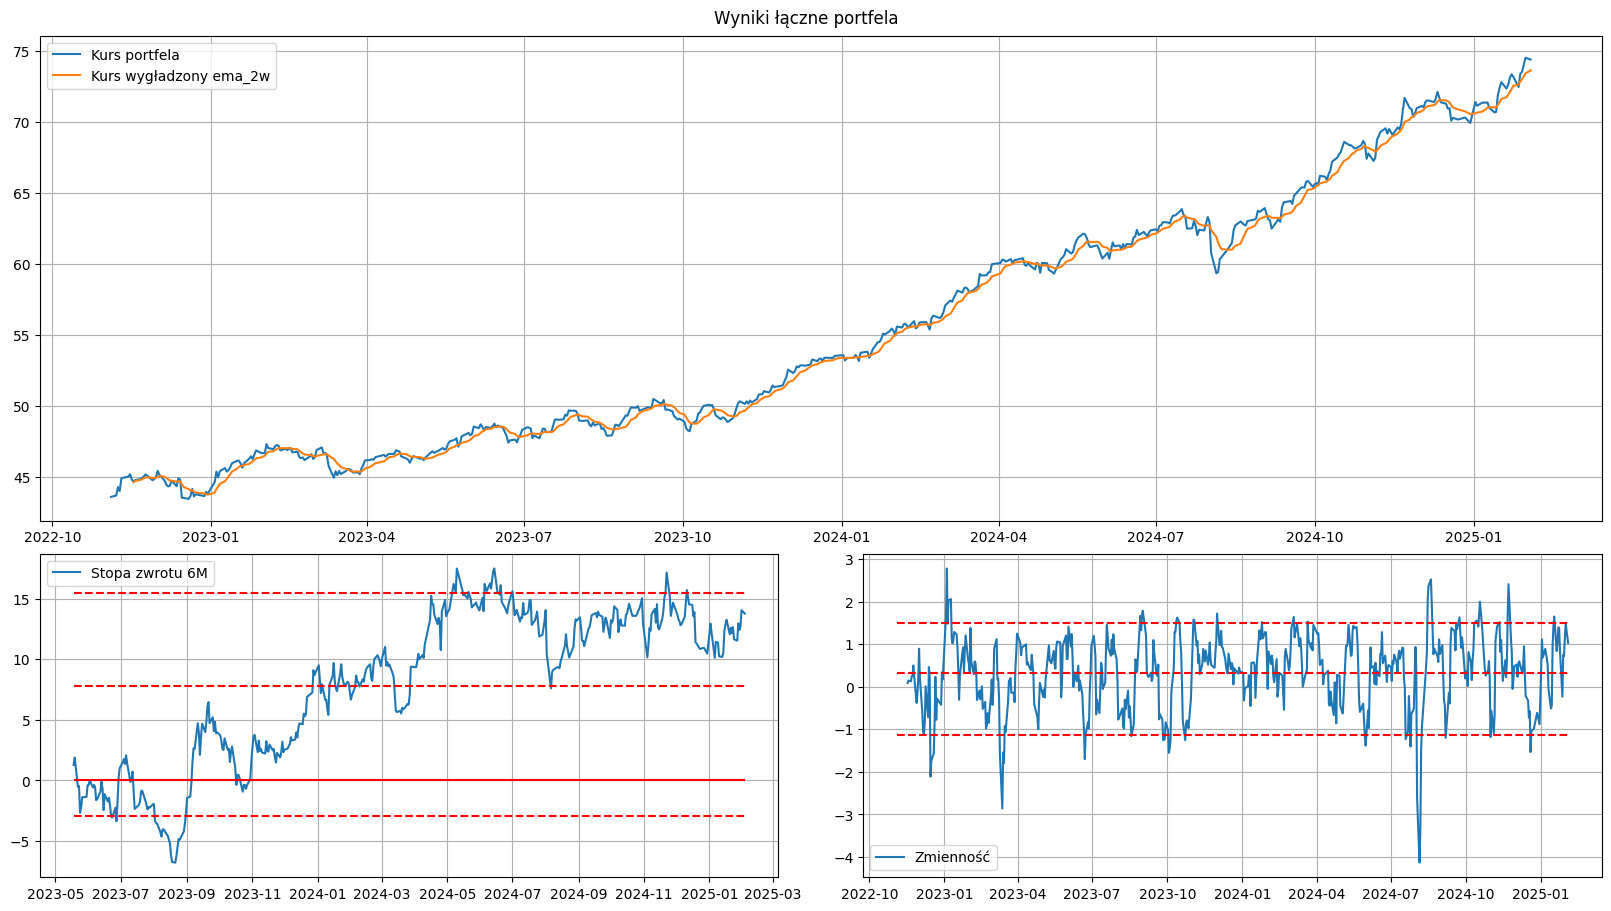

In [14]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

pl = PortfolioLoader('pos1', 'Recommendations')
freq = '6M' # można to pobrać z obiektu 'pl' jako 'pl.freq', ale można też ustawić na inną wartość

# print()
# pl.getSummary()

print()
start, end = '2020-01-01', '2025-02-03'
dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=pl.symbols)
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(freq)

plotter = Plotter(pl.portfolio,
                  data,
                  returnRates,
                  freq,
                  pl.model,
                  pl.risk_method,
                  compare='ema_2w')
plotter.plot(show_instruments=False)

## Scenariusz 5. Wykres "Efficient Frontier"

In [3]:
start, end = '2024-01-01', '2025-02-03'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info)

[INFO] Rozpoczynam pracę programu: 2025-02-04 18:02:51
[INFO] Usuwanie instrumentów o wysokich kosztach obsługi.
	Aktualizacja danych...
	Pozostawiam 953 instrumentów.
[INFO] Usuwanie instrumentów o wysokich spreadach.
	Aktualizacja danych...
	Pozostawiam 953 instrumentów.
[INFO] Usuwanie instrumentów o dużych brakach w danych.
	Aktualizacja danych...
	Pozostawiam 908 instrumentów.
[INFO] Usuwanie instrumentów na podstawie ich zmienności.
	Aktualizacja danych...
	Pozostawiam 839 instrumentów.


In [4]:
freq = '3M'
returnRates = datacleaner.getReturnRates(freq)
ef = EfficientFrontierPlot(returnRates, freq, Npoints=80)

[INFO] Przygotowuję dane do wykresu...
	Pozostało 100.0%
	Pozostało 87.5%
	Pozostało 75.0%
	Pozostało 62.5%
	Pozostało 50.0%
	Pozostało 37.5%
	Pozostało 25.0%
	Pozostało 12.5%
[INFO] Wyznaczamy portfel 'max_sharpe'...
[INFO] Wyznaczamy portfele 'max_utility'...


[INFO] Generuję 5000 portfeli losowych...
	Pozostało 100.0%
	Pozostało 90.0%
	Pozostało 80.0%
	Pozostało 70.0%
	Pozostało 60.0%
	Pozostało 50.0%
	Pozostało 40.0%
	Pozostało 30.0%
	Pozostało 20.0%
	Pozostało 10.0%
[INFO] Rysuję wykres...


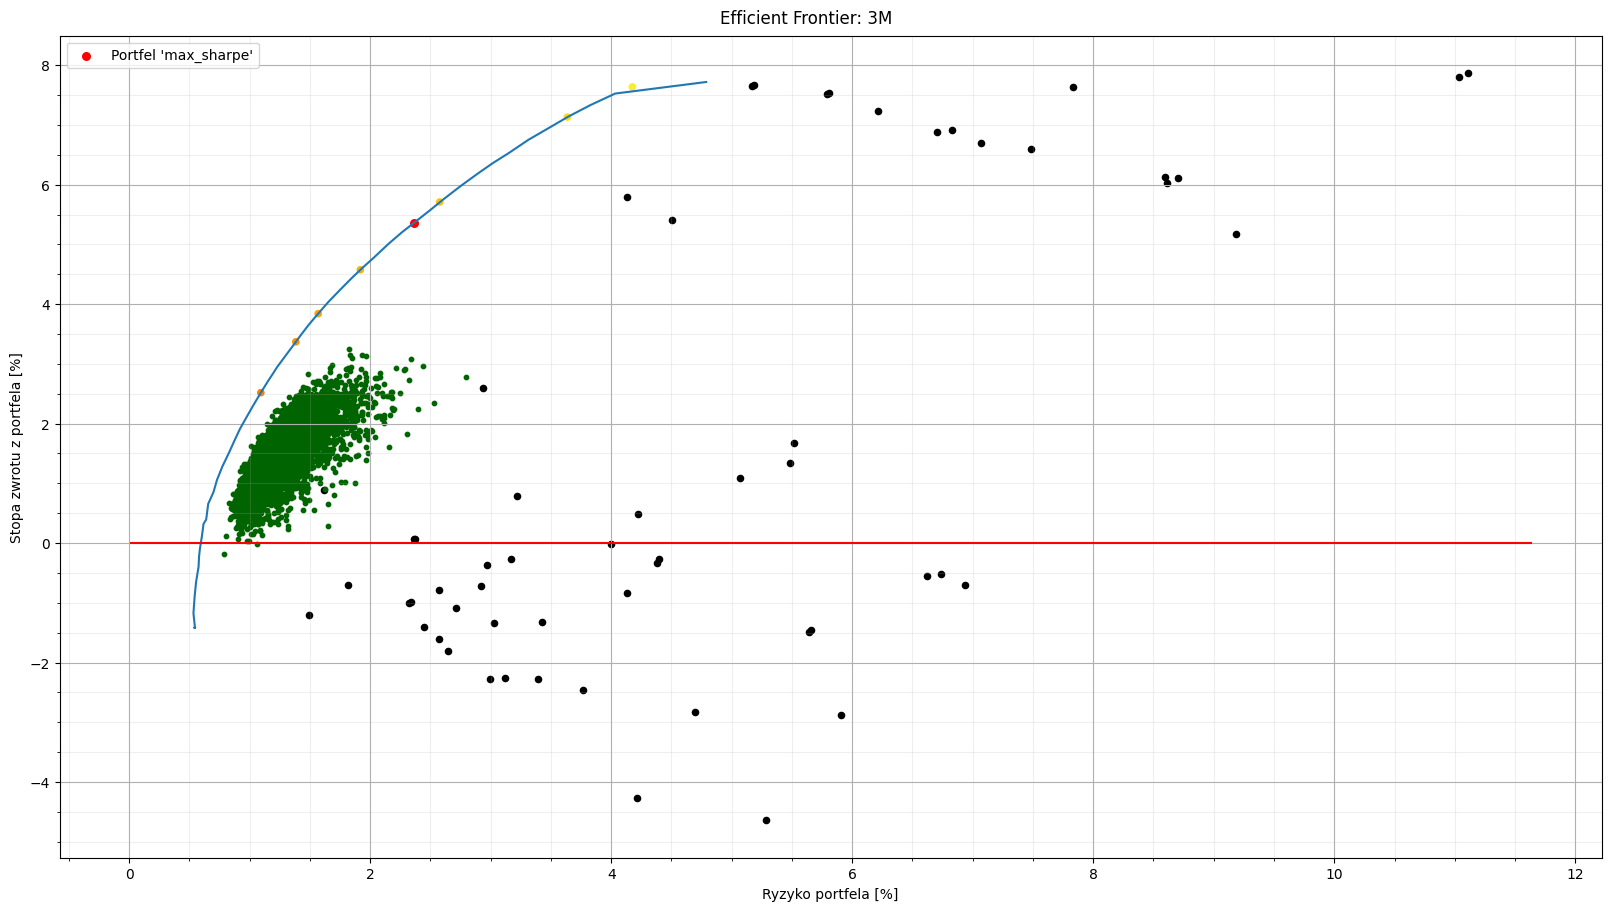

In [5]:
ef.plot(Nrandom=5000)

## Scenariusz 6: Backtest modelu

In [ ]:
start, end = '2016-07-01', '2025-03-01'

freqs = ['1w', '2w', '3w', '1M', '6w', '2M', '3M', '4M', '5M', '6M', '8M', '1Y']
len_trains = [1, 2, 3, 4, 5, 6, 7]

beginning_time = time.time()
for i, freq in enumerate(freqs):
    
    if i > 0:
        estimate_time_to_end(i, len(freqs), beginning_time)
            
    for len_train in len_trains:
        
        print(f"[INFO] Backtest z freq = {freq}, len_train = {len_train}")
        
        bt = Backtest(start, end, freq, len_train)
        bt.runTrainTest()

        BacktestSummary = bt.summary
        SaveData(BacktestSummary, f'Backtest freq {freq} len_train {len_train}', 'Backtest')
        print()

[INFO] Backtest z freq = 1M, len_train = 1
[INFO] Okres 1 z 101. Pobieramy dane od 2016-07-31 do 2016-10-31: 2025-03-02 23:47:16
	[INFO] Trening w okresie od 2016-07-31 do 2016-09-30
	Oczekiwany zwrot treningowy: 4.28%
	Sharpe Ratio: 1.37

	[INFO] Test w okresie od 2016-09-30 do 2016-10-31
	Rzeczywisty zwrot w okresie testowym: 1.50%
	Treningowy przedział ufności: [1.06%, 7.97%]

[INFO] Okres 2 z 101. Pobieramy dane od 2016-08-31 do 2016-11-30: 2025-03-02 23:47:22
	[INFO] Trening w okresie od 2016-08-31 do 2016-10-31
	Oczekiwany zwrot treningowy: 3.23%
	Sharpe Ratio: 1.95

	[INFO] Test w okresie od 2016-10-31 do 2016-11-30
	Rzeczywisty zwrot w okresie testowym: 0.85%
	Treningowy przedział ufności: [0.88%, 4.75%]

[INFO] Okres 3 z 101. Pobieramy dane od 2016-09-30 do 2016-12-31: 2025-03-02 23:47:28
	[INFO] Trening w okresie od 2016-09-30 do 2016-11-30
	Oczekiwany zwrot treningowy: 3.82%
	Sharpe Ratio: 2.45

	[INFO] Test w okresie od 2016-11-30 do 2016-12-31
	Rzeczywisty zwrot w okresie 

KeyError: 'TrueReturn'

### Zapis backtestu do jednego pliku

In [95]:
import os
files = [x for x in os.listdir('Backtest') if x.find('freq') != -1]

full_data = pd.DataFrame()

for file in files:
    
    file_split = file.split(' ')
    freq = file_split[2]
    len_train = file_split[-1][0]

    data = pd.read_csv('Backtest/'+file, index_col='Unnamed: 0')
    data['Freq'] = freq
    data['LenTrain'] = len_train
    data['StartTest'] = data.index
    data.index = range(data.shape[0])
    
    full_data = pd.concat([full_data, data])

full_data.index = range(full_data.shape[0])
full_data = full_data.dropna()
SaveData(full_data, 'Full backtest', 'Backtest')

### Ładowanie pliku z zapisem backtestu

In [104]:
data = pd.read_csv('Backtest/Full backtest.csv', index_col='Unnamed: 0').drop(index=[787])
data.head()

,ExpectedReturn,ConfIntLow,ConfIntHigh,SharpeRatio,TrueReturn,Error,InConfInt,Freq,LenTrain,StartTest
0,4.28,1.06,7.97,1.367520,1.50,-2.78,True,1M,1,2016-09-30
1,3.23,0.88,4.75,1.951575,0.85,-2.38,False,1M,1,2016-10-31
2,3.82,1.85,5.32,2.449936,4.60,0.78,True,1M,1,2016-11-30
3,6.51,5.49,7.58,6.317600,4.61,-1.90,False,1M,1,2016-12-31
4,0.91,-0.20,2.08,0.401199,-0.61,-1.52,False,1M,1,2017-01-31


In [105]:
data['SharpeClass'] = data['SharpeRatio'].apply(lambda x: int(x))

### Analiza wyników backtestu

In [112]:
pd.crosstab(data['InConfInt'], data['LenTrain'], normalize='columns')

LenTrain,1,2,3,4,5,6,7
InConfInt,,,,,,,
False,0.306583,0.238404,0.212828,0.187564,0.221267,0.183371,0.187275
True,0.693417,0.761596,0.787172,0.812436,0.778733,0.816629,0.812725


<AxesSubplot: title={'center': 'TrueReturn'}, xlabel='[LenTrain]'>

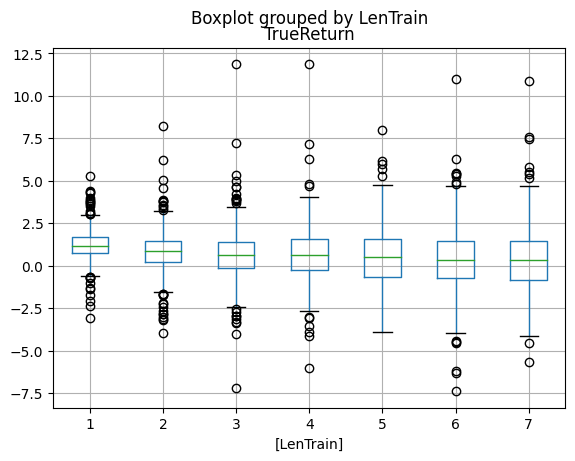

In [115]:
data.query("Freq == '1w'")[['TrueReturn', 'LenTrain']].boxplot(by='LenTrain', grid=True)

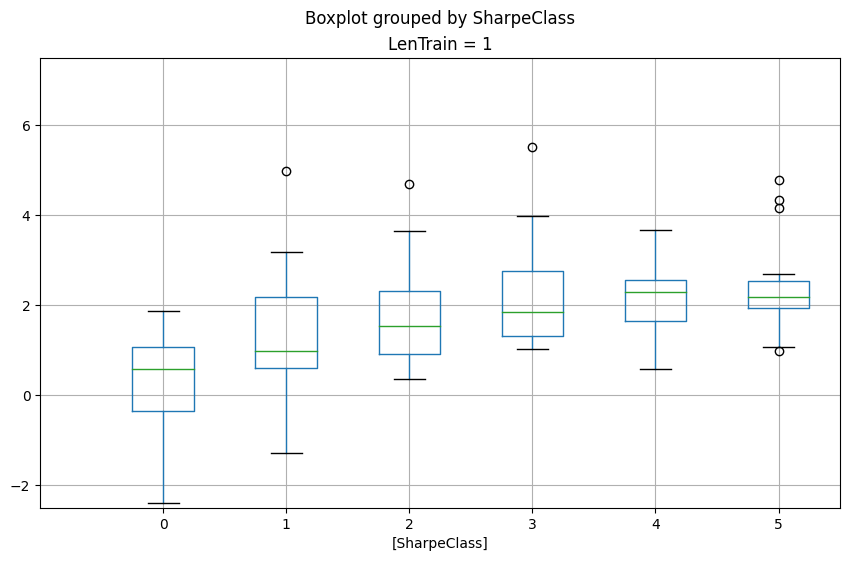

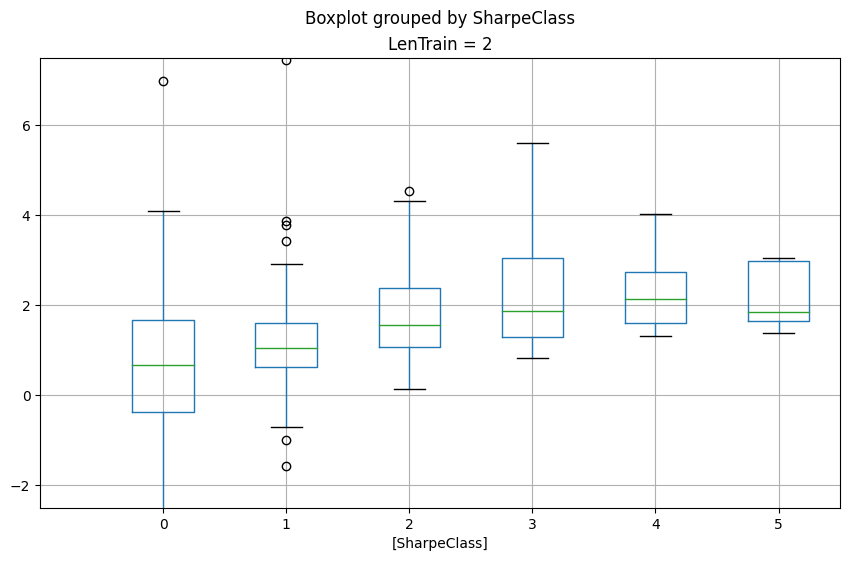

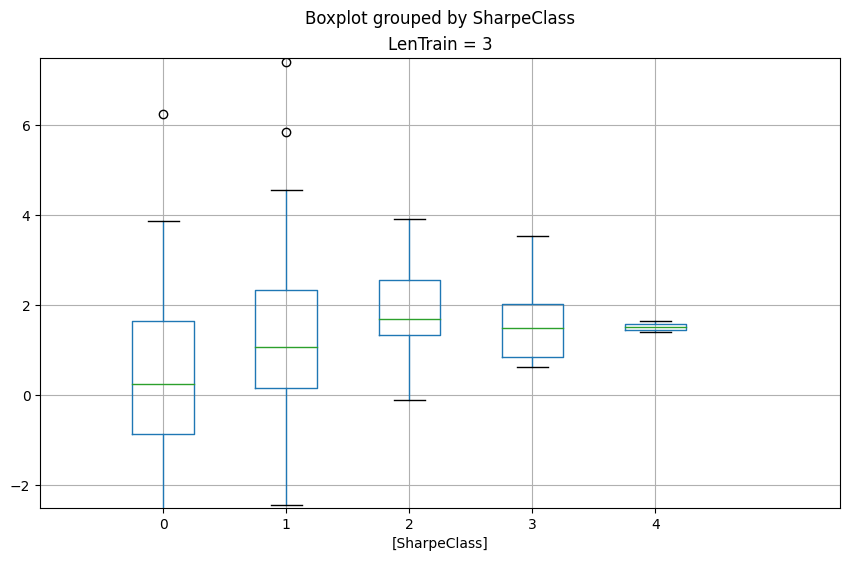

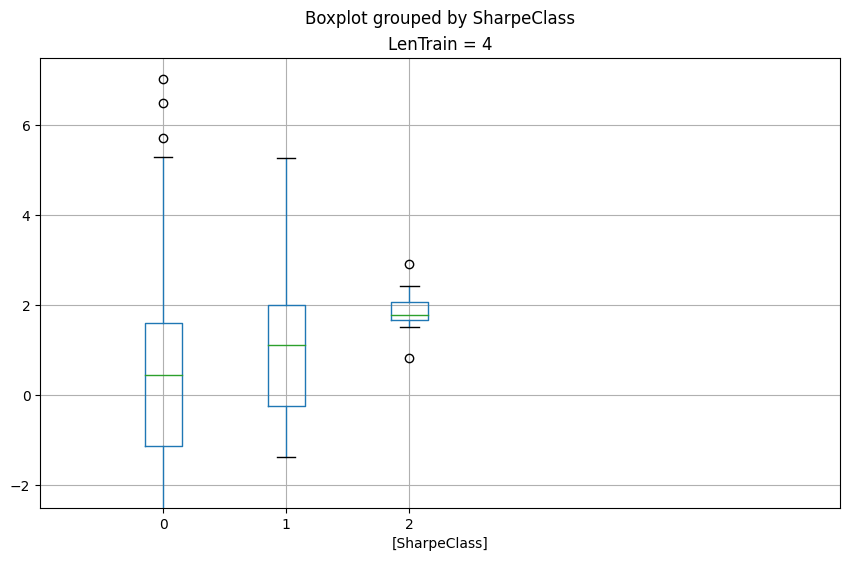

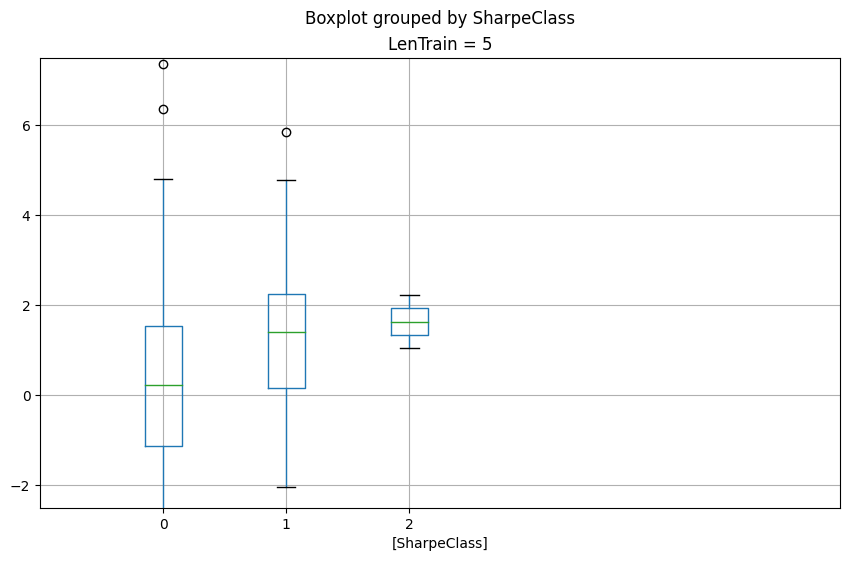

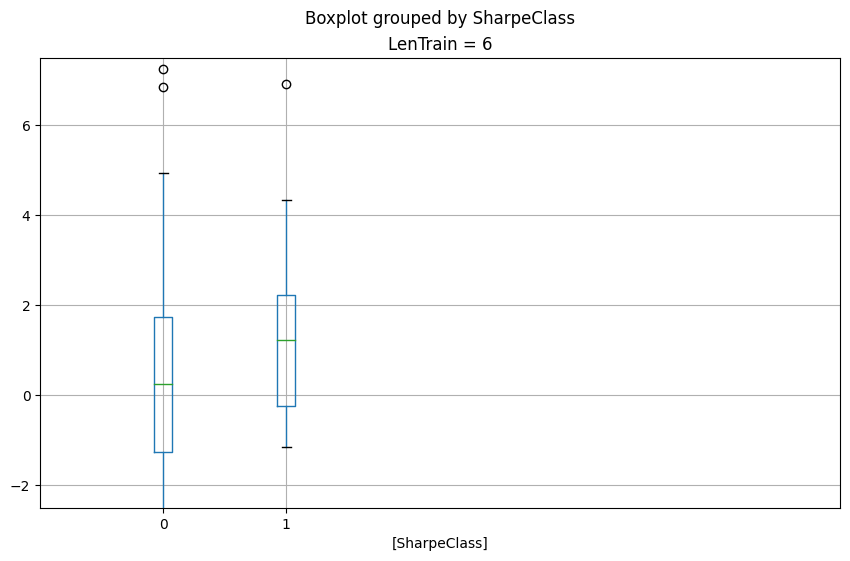

In [136]:
for i in range(1, 7):
    df = data.query(f"Freq == '2w' and LenTrain == {i}")[['TrueReturn', 'SharpeClass']]
    ax = df.boxplot(by='SharpeClass', figsize=(10, 6), grid=True)
    ax.set_title(f"LenTrain = {i}")
    ax.set_ylim(-2.5, 7.5)
    ax.set_xlim(0, 6.5)

# Brudnopis

In [182]:
dl = DataLoader(cfg.user_id, cfg.pwd)
dl.connect()
response = dl.client.commandExecute('getSymbol', arguments={'symbol': 'FLXI.DE'})
returnData = response['returnData']
stepRules = dl.client.commandExecute('getStepRules')['returnData']
dl.disconnect()

	[2025-03-03 17:42:45] Loguję do API...
	[2025-03-03 17:42:45] Wylogowuję z API...
